# Evolution strategies on test functions for optimization

## Test functions for optimization

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lagom.core.es.test_functions import Rastrigin
from lagom.core.es.test_functions import Sphere
from lagom.core.es.test_functions import StyblinskiTang
from lagom.core.es.test_functions import HolderTable


def plot_contour(f, num_points=100):
    x = np.linspace(*f.search_domain, num=num_points)
    y = np.linspace(*f.search_domain, num=num_points)
    x, y = np.meshgrid(x, y)
    
    # Compute function values
    z = f([x, y])
    
    fig, ax = plt.subplots(1, 1)
    ax.contourf(x, y, z, cmap='jet')
    
    return fig

# Sometimes it needs to run cell twice to show figure
fig = plot_contour(Rastrigin())

## Naive version (No parallelization)

In [3]:
def solve(es_optimizer, max_iter, log_interval=1):
    r"""Solve
    
    Args:
        es_optimizer (ESOptimizer): ES optimizer
        max_iter (int): maximum number of iterations (generations)
        log_interval (int): log interval
    """
    list_best_f_val = []
    
    for i in range(max_iter):
        # Perform one iteration
        results = es_optimizer.step()
        
        # Logging
        best_f_val = results['best_f_val']
        list_best_f_val.append(best_f_val)
        if i == 0 or (i+1)%log_interval == 0:
            print(f'Objective function value at iteration #{i+1}: {best_f_val}')
    
    # Final logging
    best_param = results['best_param']
    print(f'# Local optimum discovered by ES solver: {best_param}')
    print(f'# Its objective function value: {best_f_val}')
    
    return list_best_f_val

In [4]:
import numpy as np

from lagom.core.es import ESOptimizer
from lagom.core.es import CMAES, OpenAIES


# Seeding
seed = 0
np.random.seed(seed)

all_es = {}
all_best_f_val = {}

# Create and record all ES algorithms
cmaes = CMAES(mu0=[3]*100, 
              std0=0.5, 
              popsize=12)
all_es['CMAES'] = cmaes

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=False, 
                    rank_transform=False)
all_es['OpenAI ES'] = openaies

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=True, 
                    rank_transform=False)
all_es['OpenAI ES with antithetic'] = openaies

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=False, 
                    rank_transform=True)
all_es['OpenAI ES with rank'] = openaies

openaies = OpenAIES(mu0=[3]*100, 
                    std0=0.5, 
                    popsize=50, 
                    std_decay=0.999,
                    min_std=0.01, 
                    lr=1e-1, 
                    lr_decay=1.0, 
                    min_lr=1e-1, 
                    antithetic=True, 
                    rank_transform=True)
all_es['OpenAI ES with antithetic and rank'] = openaies

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 100 (seed=59104, Thu Sep 27 12:26:58 2018)


In [5]:
from time import time
from datetime import timedelta


t = time()

for name, es in all_es.items():
    print('#'*50)
    print(f'ES: {name}')
    print('#'*50)
    
    es_optimizer = ESOptimizer(es, Rastrigin())

    list_best_f_val = solve(es_optimizer=es_optimizer, 
                            max_iter=1000, 
                            log_interval=100)
    
    all_best_f_val[name] = list_best_f_val

print(f'\nTotal time: {timedelta(seconds=round(time() - t))}')

##################################################
ES: CMAES
##################################################
Objective function value at iteration #1: 1825.6248954977666
Objective function value at iteration #100: 1509.538865463609
Objective function value at iteration #200: 1300.96988831946
Objective function value at iteration #300: 1200.924129206249
Objective function value at iteration #400: 947.6982389587548
Objective function value at iteration #500: 511.89816966151943
Objective function value at iteration #600: 456.8560111192241
Objective function value at iteration #700: 453.0666501076656
Objective function value at iteration #800: 452.721268422935
Objective function value at iteration #900: 452.70500075090104
Objective function value at iteration #1000: 452.70406573945667
# Local optimum discovered by ES solver: [ 3.97980194e+00 -1.99001159e+00  2.98475237e+00  4.10291357e-05
  1.98998724e+00 -5.21023489e-05  3.20892270e-05  1.98977391e+00
  2.98484525e+00  3.97966628e+00  

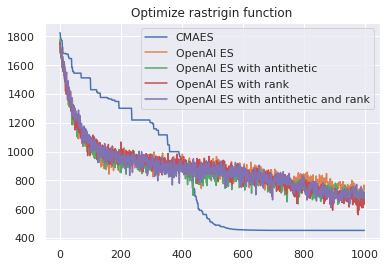

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig, ax = plt.subplots(nrows=1, ncols=1)

for name, best_f_val in all_best_f_val.items():
    ax.plot(best_f_val, label=f'{name}')

ax.set_title('Optimize rastrigin function')
ax.legend()

## Parallelized ES

In [7]:
from lagom.core.es import CMAES, OpenAIES

from lagom.core.es.test_functions import Rastrigin

from lagom.core.es import BaseESWorker
from lagom.core.es import BaseESMaster

from time import time
from datetime import timedelta


class ESWorker(BaseESWorker):
    def prepare(self):
        self.rastrigin = Rastrigin()
        
    def f(self, solution, seed, config):
        assert config is None
        
        function_value = self.rastrigin(solution)
        
        return function_value
    

class ESMaster(BaseESMaster):
    def make_es(self, config):
        assert config is None
        
        cmaes = CMAES(mu0=[3]*100, 
                      std0=0.5, 
                      popsize=12)
        
        return cmaes
        
    def _process_es_result(self, result):
        best_f_val = result['best_f_val']
        if self.generation == 0 or (self.generation+1) % 100 == 0:
            print(f'Best function value at generation {self.generation+1}: {best_f_val}')
            

t = time()
            
es = ESMaster(num_iteration=1000, 
              worker_class=ESWorker, 
              init_seed=0, 
              daemonic_worker=None, 
              config=None)

es()

print(f'\nTotal time: {timedelta(seconds=round(time() - t))}')

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 100 (seed=120242, Thu Sep 27 12:28:10 2018)
Best function value at generation 1: 1754.2488584024074
Best function value at generation 100: 1513.2014436842342
Best function value at generation 200: 1242.3494396422243
Best function value at generation 300: 1237.0177451976585
Best function value at generation 400: 1237.0177451976585
Best function value at generation 500: 1194.4637177621942
Best function value at generation 600: 1000.7805079406307
Best function value at generation 700: 699.5641829127501
Best function value at generation 800: 436.08863531156794
Best function value at generation 900: 406.9702274586276
Best function value at generation 1000: 405.06307372285863

Total time: 0:00:19
